In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions
sess = tf.InteractiveSession()

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Bayesian Logistic Regression
An implementation of logistic regression using Tensorflow Probability. We learn the distribution using MCMC and plot the MAP and 5% and 95% confidence.

In [2]:
LOC, SCALE = 35., .25 
x = np.arange(0, 100, 1.)

def generate(loc, scale):
    z = scale * (x - loc)
    return tfd.Bernoulli(logits=z)

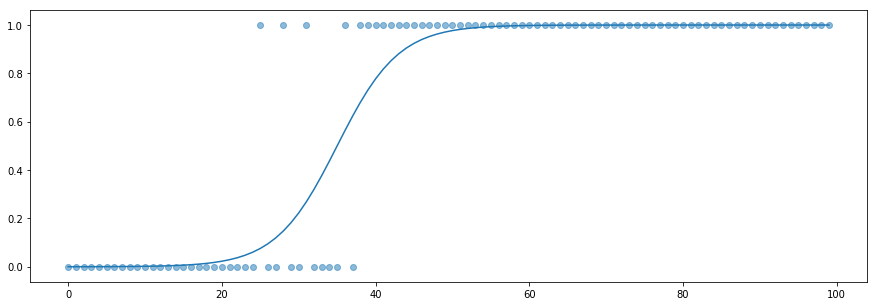

In [3]:
model = generate(LOC, SCALE)
y = sess.run(model.sample(1))
yp = sess.run(model.probs)
plt.figure(figsize=(15, 5))
plt.scatter(x, y[0], alpha=.5)
plt.plot(x, yp)
plt.show()

Now we define the `log_prob` to guide our MCMC sampling with the following priors:
- The loc (transition point) for our logistic is normally distributed with mean 50 and variance 10
- The scale is Gamma distributed around 1 with variance of 1

In [4]:
def log_prob_prior(loc, scale):
    rv_loc = tfd.Normal(loc=50, scale=10.)
    rv_scale = tfd.Gamma(rate=1., concentration=1.)
    return rv_loc.log_prob(loc) + rv_scale.log_prob(scale)

def log_prob_data(loc, scale):
    rv_y = generate(loc, scale)
    return tf.reduce_sum(rv_y.log_prob(y))
    
def log_prob(*args):
    return log_prob_prior(*args) + log_prob_data(*args)

Now we sample the posterior to get our location and scale estimates.

In [5]:
with tf.variable_scope(tf.get_variable_scope(), reuse=tf.AUTO_REUSE):
    step_size = tf.get_variable(
        name='step_size',
        initializer=tf.constant(0.5, dtype=tf.float32),
        trainable=False,
        use_resource=True
    )

kernel = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=log_prob,
    num_leapfrog_steps=2,
    step_size=step_size,
    step_size_update_fn=tfp.mcmc.make_simple_step_size_update_policy(),
    state_gradients_are_stopped=True)

samples = tfp.mcmc.sample_chain(
    num_results=1000,
    num_burnin_steps=1000,
    current_state=[LOC, SCALE],
    kernel=kernel)

sess.run(tf.global_variables_initializer())
[loc_samples, scale_samples], results = sess.run(samples)

In [6]:
pct = [.05, .5, .95]
loc_pct = np.percentile(loc_samples, pct)
scale_pct = np.percentile(scale_samples, pct)
yp05 = sess.run(generate(loc_pct[0], scale_pct[0]).probs)
yp50 = sess.run(generate(loc_pct[1], scale_pct[1]).probs)
yp95 = sess.run(generate(loc_pct[2], scale_pct[2]).probs)

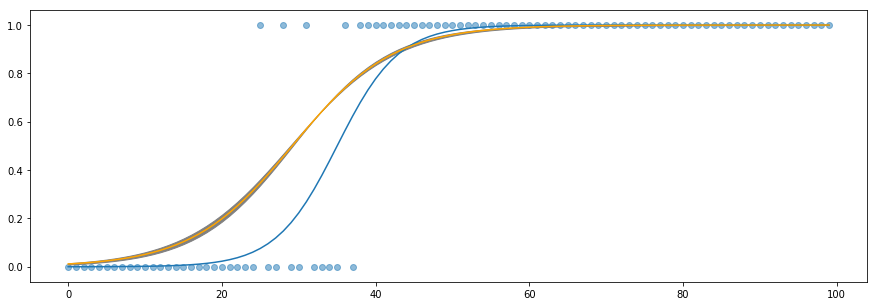

In [7]:
plt.figure(figsize=(15, 5))
plt.scatter(x, y[0], alpha=.5)
plt.plot(x, yp)
plt.plot(x, yp50, color='orange')
plt.fill_between(x, yp05, yp95, color='grey')
plt.show()